# Stochastic Processes
## Practical HW1
Fall 1401 - Dr. Rabiee

Name: Amirhossein Abedi

Student Number: 99105594

### Required imports

In [14]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
plt.rcParams["figure.figsize"] = (15,10)

# You are allowed to use any other library. But note, your notebook must be able to run,
# so it is necessary to add !pip install commannds to install the desired libraries.
# You must add any import command here and !pip install here.
!pip install scipy
from scipy.stats import norm

## Gaussian Process

### Fit Gaussian


#### Univariate Gaussian
1. In this section, we just want to fit a univariate Gaussian to the data in `data1.npy`. <br>
2. Plot the samples and the final graph in one graph.

As you know a random variable follows a univariate Gaussian distribution if its probability density function is given 
$$p(x)=\frac{1}{(2\pi\sigma^2)^{1/2}}\text{exp}\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$

### Lets first see the data 

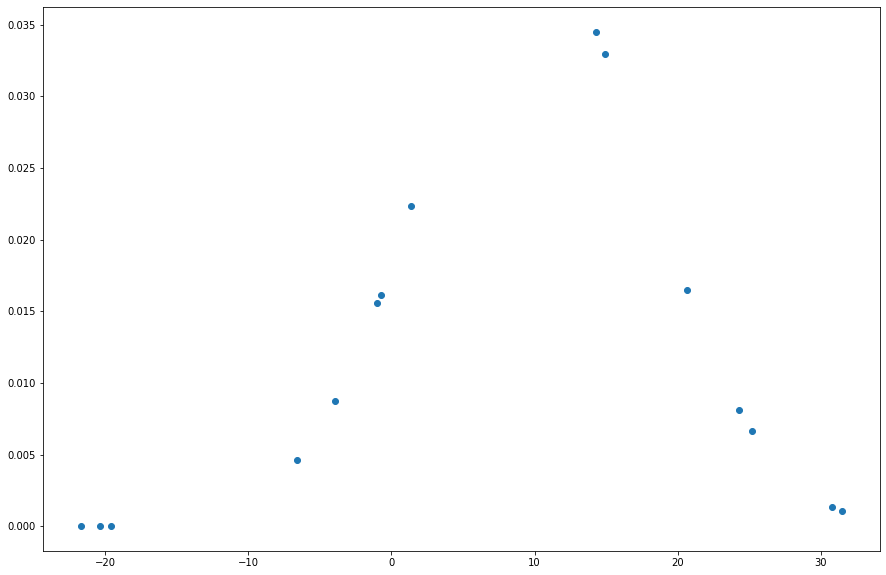

In [18]:
arr = np.load('data1.npy')
x = arr[0]
y = arr[1]
plt.scatter(x, y)

First we take samples from the given data.

Sampling is done as below:

in each step take $x_i$ with probability $p_i$.

Where each $p_i$ can be obtained from :
$$
p_i = \frac{y_i}{\sum_k y_k}
$$
Now we can define the mean and standard deviation as:
$$
\mu = \frac{1}{n}\sum_iS_i\quad,\quad\sigma^2 = \frac{1}{n - 1}\sum_i(S_i - \bar{S})^2
$$
Where each $S$ is a sample point and $\bar{S}$ is the sample mean.

In [19]:
probs = [0]
for i in y:
    probs.append(i + probs[-1])
for i in range(len(probs)):
    probs[i] = probs[i] / probs[-1]

In [20]:
samples = []
for i in range(10000):
    seed = np.random.random()
    for i in range(1, len(probs)):
        if seed <= probs[i]:
            samples.append(x[i - 1])
            break
mu = np.mean(samples)
sigma = np.std(samples) * np.sqrt(len(samples)/(len(samples) - 1))
print(f'mean = {mu}, ', f'std = {sigma}')

mean = 10.028060612457711,  std = 9.724769423360302


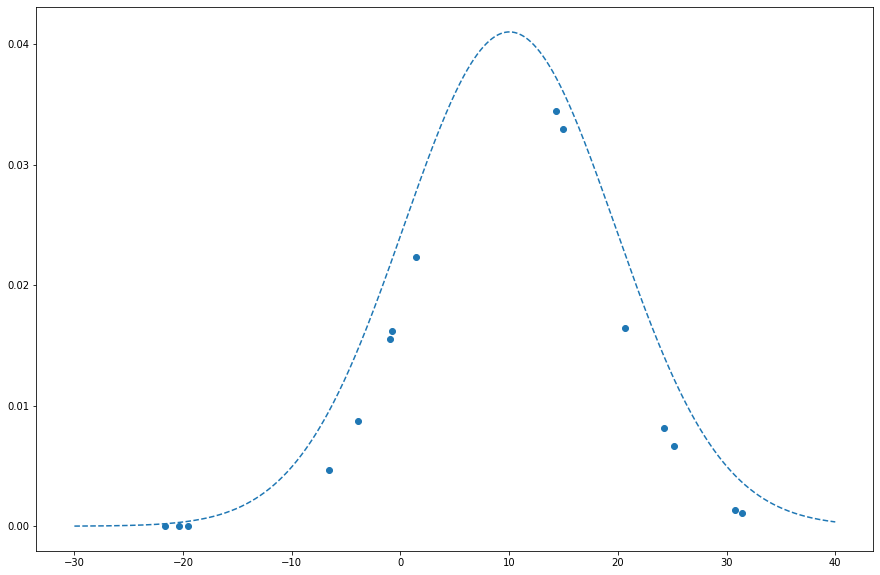

In [21]:
plt.scatter(x, y)
plt.plot(np.linspace(-30, 40, num=1000), [norm.pdf(i, loc=mu, scale=sigma) for i in np.linspace(-30, 40, num=1000)], '--')

#### Multivariate Gaussian
1. In `data2.npy`, a set of points is stored as $(x_1,x_2)$. Try to fit a two-variable Gaussian to this data points.
2. For this, obtain the mean vector and the covariance matrix of the bivariate Gaussian.

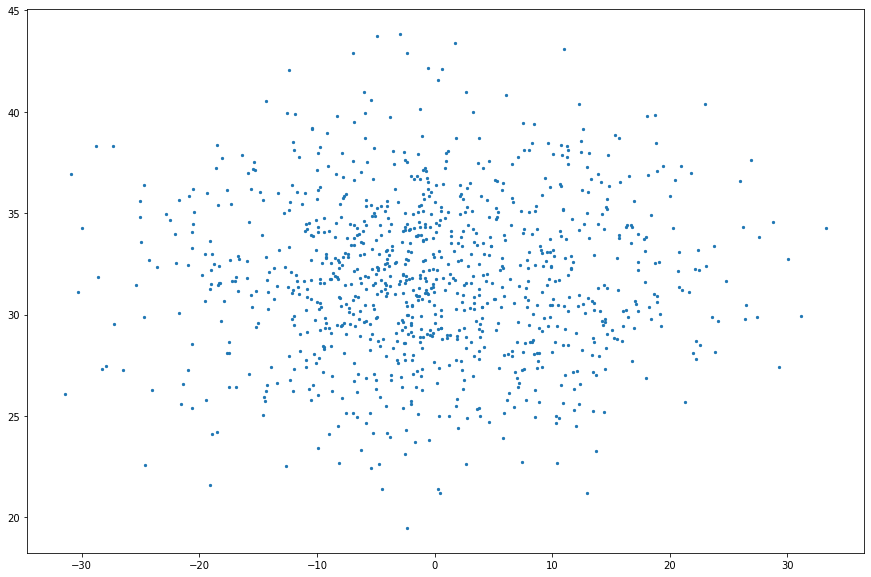

In [22]:
arr = np.load('data2.npy')
x, y = arr[:, 0], arr[:, 1]
plt.scatter(x, y, s=5)

First we estimate $\mu_1$ and $\mu_2$ from sample means and also estimate $\text{Cov}(X_i, X_j)$ ( for $i, j \in \{1, 2\}$ ) as:
$$
\text{Cov}(X_i, X_j) = \mathbb{E}[X_iX_j] - \mathbb{E}[X_i]\mathbb{E}[X_j]
$$


Which can be drawn from samples. Note that for $i = j$:
$$
\text{Cov}(X_i, X_i) = \mathbb{E}[X_i^2] - \mathbb{E}[X_i]^2 = \text{ Sample variance}
$$

In [10]:
mu = np.zeros((2))
k = np.zeros((2, 2))

mu[0] = np.mean(x)
mu[1] = np.mean(y)

k[0, 0] = np.mean(x*x) - mu[0]**2
k[0, 1] = k[1, 0] = np.mean((x - mu[0])*(y - mu[1]))
k[1, 1] = np.mean(y*y) - mu[1]**2

print(f'mean = {mu}, ', f'\ncov matrix = \n{k}')

mean = [-0.26895121 31.83196193],  
cov matrix = 
[[123.83634371   0.81503884]
 [  0.81503884  15.69411757]]


In [11]:
from scipy.stats import multivariate_normal

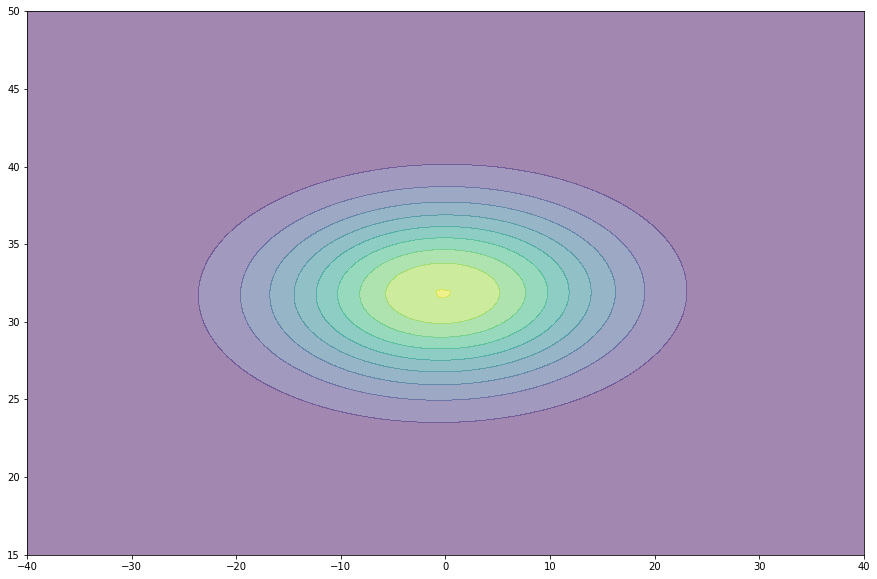

In [15]:
rv = multivariate_normal(mu, k)
x_plot = np.linspace(-40, 40, num=100)
y_plot = np.linspace(15, 50, num=100)
val = np.zeros((y_plot.size, x_plot.size))

for i in range(y_plot.size):
    for j in range(x_plot.size):
        val[i, j] = rv.pdf([x_plot[j], y_plot[i]])

plt.contourf(x_plot, y_plot, val, levels=10, alpha=0.5)

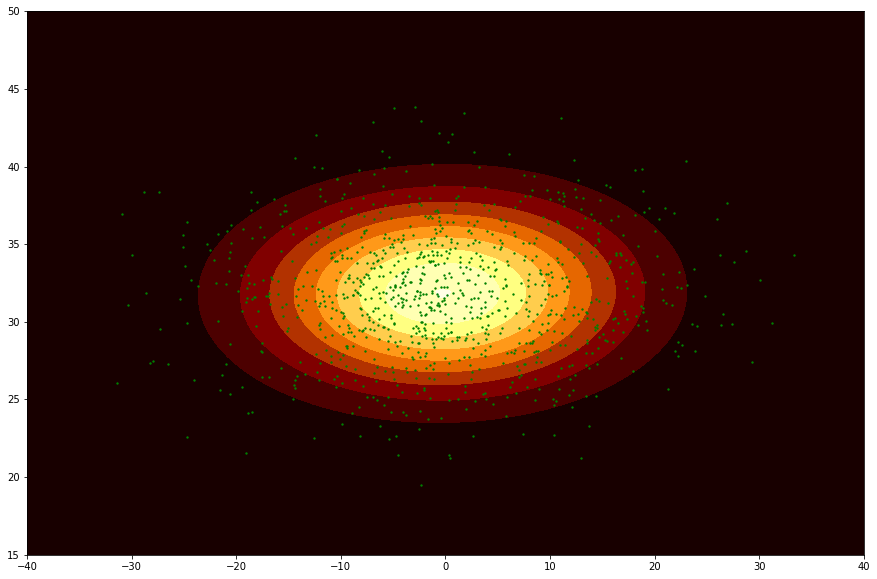

In [16]:
plt.contourf(x_plot, y_plot, val, levels=10, alpha=1, cmap='afmhot')
plt.scatter(x, y, c='green', s= 1.8)

Above graph is the points + contour map the found bivariate normal.

### Generate Gaussian Processes
1. Generate 10 Gaussian processes with $\mu(t)=2\log(t)$ and rbf kernel: $e^{-(x_1-x_2)^2/{2\sigma^2}}$ with $\sigma^2$=0.05, in the interval [0,4].
2. Show the processes as well as $\mu(t)$ in a single plot. (set the number of samples as large as the graphs seem smooth)

First we need to define a function to give a sample from a given gaussian process. This function takes in a vector of means and a kernel matrix and returns one sample.

We take the following approach. Suppose $X\sim \mathcal{N}(\mu, K)$. First we find the cholesky factor $L$ for $K$ such that $LL^T = K$. Then $X = LZ + \mu$ where $Z\sim\mathcal{N}(0, I)$.

If the cholesky factorization doesn't exist, we can sample the last element and condition others on it.

In [66]:
def gp_sample(m, ker):
    rv = multivariate_normal(np.zeros(m.size), np.eye(m.size))
    ret = rv.rvs(size = 1)
    try:
        return np.linalg.cholesky(ker) @ ret + m
    except:
        if ker[-1][-1] <= 10e-12:
            if m.size == 1:
                return np.array([m[-1]])
            return np.hstack([gp_sample(m[:-1], ker[:-1, :-1]), np.array([m[-1]])])
        else:
            x_end = norm(m[-1], ker[-1][-1]).rvs(size = 1)
            if m.size == 1:
                return x_end
            new_m = m[:-1] + (ker[:-1, -1:] @ (x_end - m[-1])) / ker[-1][-1]
            new_ker = ker[:-1, :-1] - (ker[:-1, -1:] @ ker[:-1, -1:].T)/ ker[-1][-1]
            return np.hstack([gp_sample(new_m, new_ker), x_end])


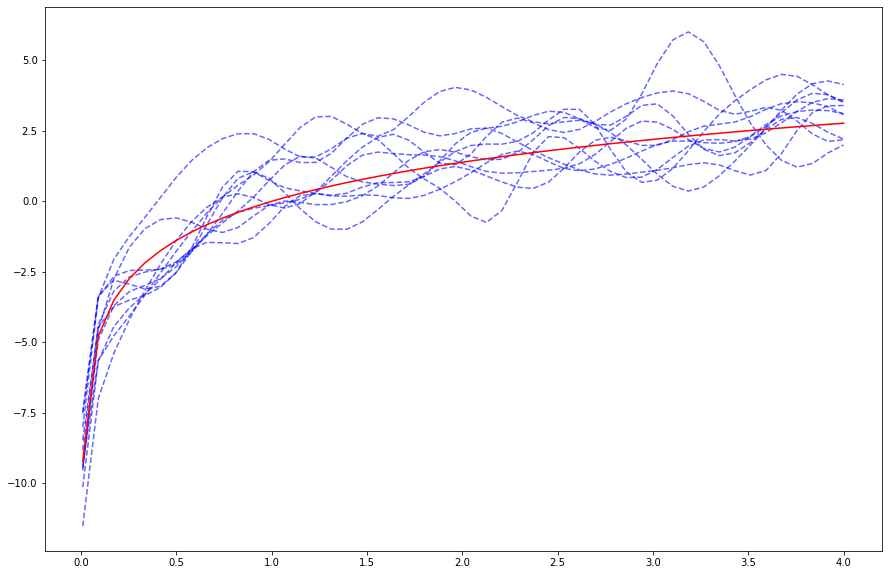

In [70]:
def rbf(x1, x2):
    sigma_2 = 0.05
    return np.exp(-(np.linalg.norm(x1 - x2)**2)/(2*sigma_2))

indices = np.linspace(0.01, 4, num = 50)
mu = 2* np.log(indices)
k = np.zeros((indices.size, indices.size))
for i, xi in enumerate(indices):
    for j, xj in enumerate(indices):
        k[i, j] = rbf(xi, xj)
for _ in range(10):
    plt.plot(indices, gp_sample(mu, k), '--', c='blue', alpha=0.6)
plt.plot(indices, mu, c='red')

#### Brownian Motion
Brownian motion is a type of Gaussian process in which the change of its value through time completely random.  
A standard Brownian motion as a Gaussian process has zero mean, and kernel $k(s, t) = \min{(s, t)}$
<br>
1. Generate 10 Brownian motions in the interval [0, 1].
2. Draw the processes in a single plot with different colors.

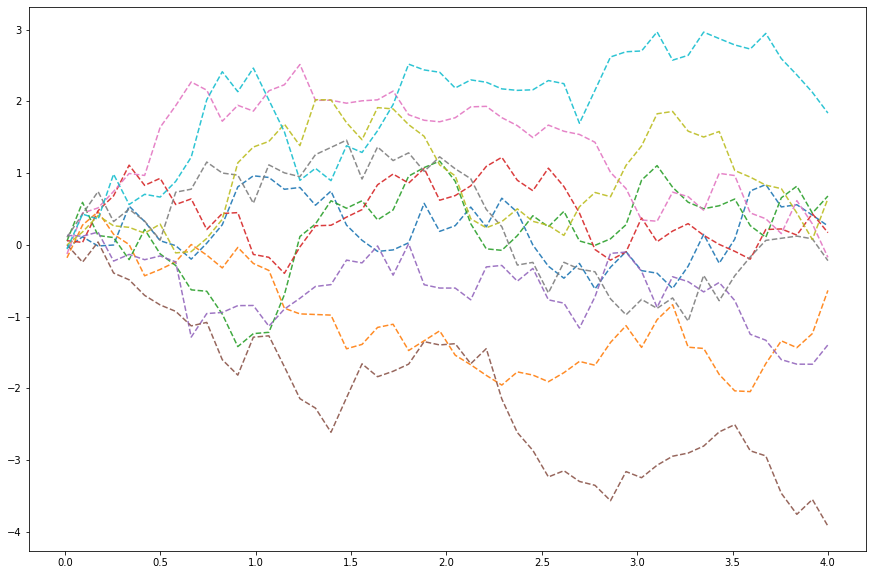

In [72]:
def brownian_kernel(x1, x2):
    return min(x1, x2)

indices = np.linspace(0, 4, num = 50)
mu = np.zeros((indices.size))
k = np.zeros((indices.size, indices.size))
for i, xi in enumerate(indices):
    for j, xj in enumerate(indices):
        k[i, j] = brownian_kernel(xi, xj)
for _ in range(10):
    plt.plot(indices, gp_sample(mu, k), '--', alpha=0.9)

As you can see, in the Brownian process, the process gradually moves away from the average value and moves on a new trend.

1. Again generate a Brownian process around zero mean.
2. Apply a linear regression to the above process and by subtracting the data value from this trend, put the mean around zero.
3. This time remove the trend using the ‍‍‍‍**Differencing** method. (these two methods are called **Detrending**)

In [73]:
!pip install sklearn
from sklearn.linear_model import LinearRegression

### Linear regression


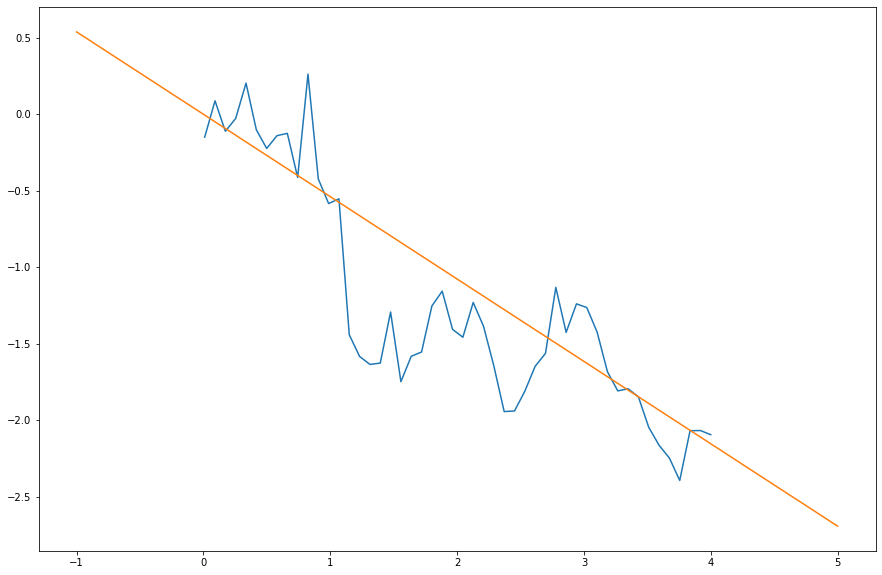

In [104]:
def linear_weights(t, x): # returns detrended data
    a = np.ones((t.size, 2))
    a[:, 1] = t
    return LinearRegression(fit_intercept=True).fit(a, x).coef_
    
b = gp_sample(mu, k)
w0, w1 =  linear_weights(indices, b)
plt.plot(indices, b)
plt.plot(np.linspace(-1, 5, num=20), np.linspace(-1, 5, num=20)*w1 + w0)

Now that we have the linear coeeficients we can write the detrend function:


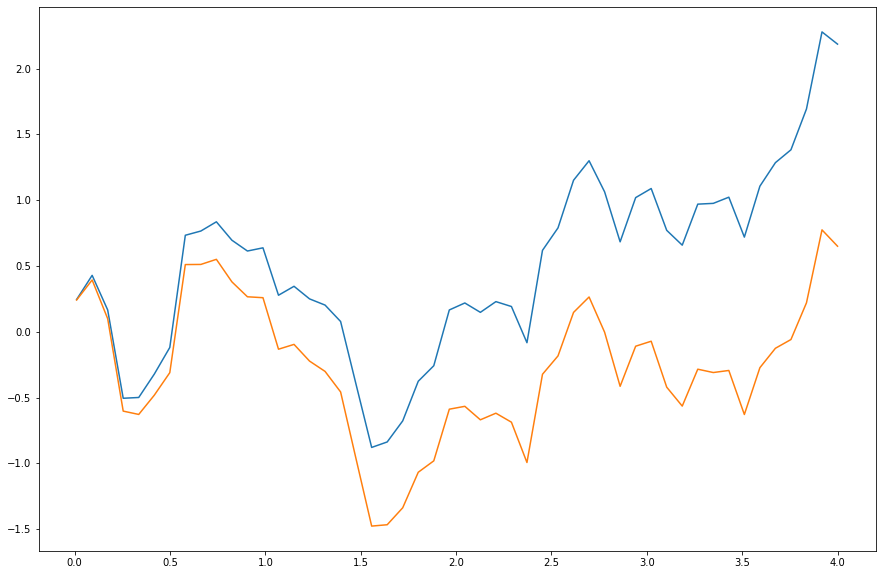

In [107]:
def detrend(t, x):
    w0, w1 = linear_weights(t, x)
    return x - w1*t - w0  

s = gp_sample(mu, k)
plt.plot(indices, s)
plt.plot(indices, detrend(indices, s))

Now we can generate the random brownian process.

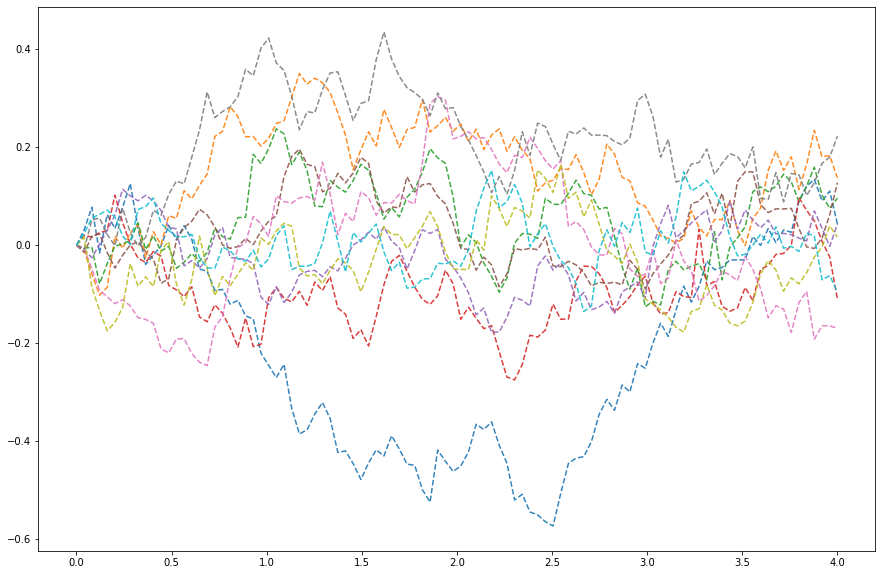

In [110]:
indices = np.linspace(0, 4, num = 100)
mu = np.zeros((indices.size))
k = np.zeros((indices.size, indices.size))
for i, xi in enumerate(indices):
    for j, xj in enumerate(indices):
        k[i, j] = brownian_kernel(xi, xj)
for _ in range(10):
    plt.plot(indices, detrend(indices, gp_sample(mu, k)), '--', alpha=0.9)

### Differencing

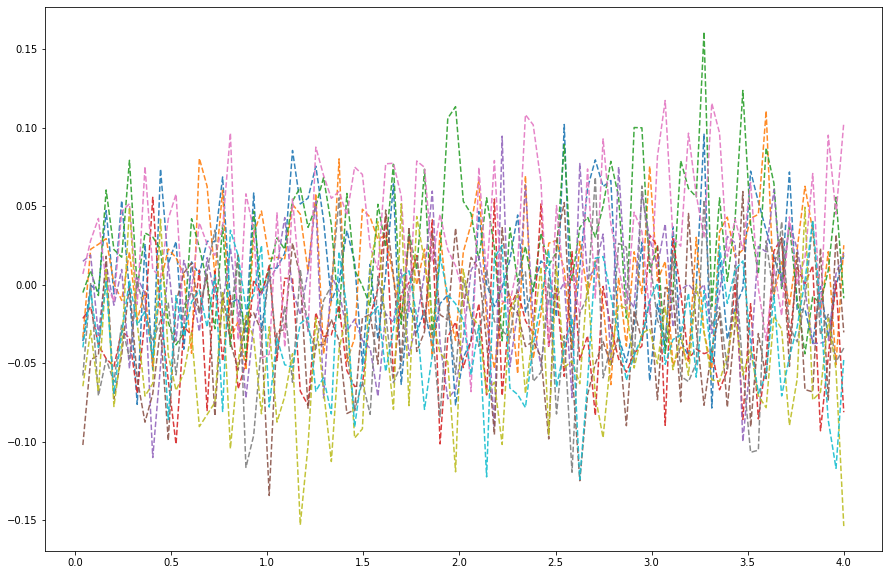

In [114]:
indices = np.linspace(0, 4, num = 100)
mu = np.zeros((indices.size))
k = np.zeros((indices.size, indices.size))
for i, xi in enumerate(indices):
    for j, xj in enumerate(indices):
        k[i, j] = brownian_kernel(xi, xj)
for _ in range(10):
    s = gp_sample(mu, k) 
    plt.plot(indices[1:], s[1:] - s[:-1], '--', alpha=0.9)

### Gaussian process with different kernels
In this section, we want to try some other kernels.
Suppose all following processes are Gaussian with zero mean. <br>
1. $k(s, t) = \delta(s-t)$
2. $k_{w, a}(s, t) = \arcsin\left(\frac{w(s-a)(t-a)}{\sqrt{(w(s-a)(s-a)+1)(w(t-a)(t-a)+1)}}\right)$
3. $k_a(s, t) = (s-a)(t-a)$

You should generate 10 processes in the interval [0,1] with each kernel and display them in a plot as before. (each kernel in a separate plot)

Text(0.5, 1.0, 'Kernel 1 -> dirac')

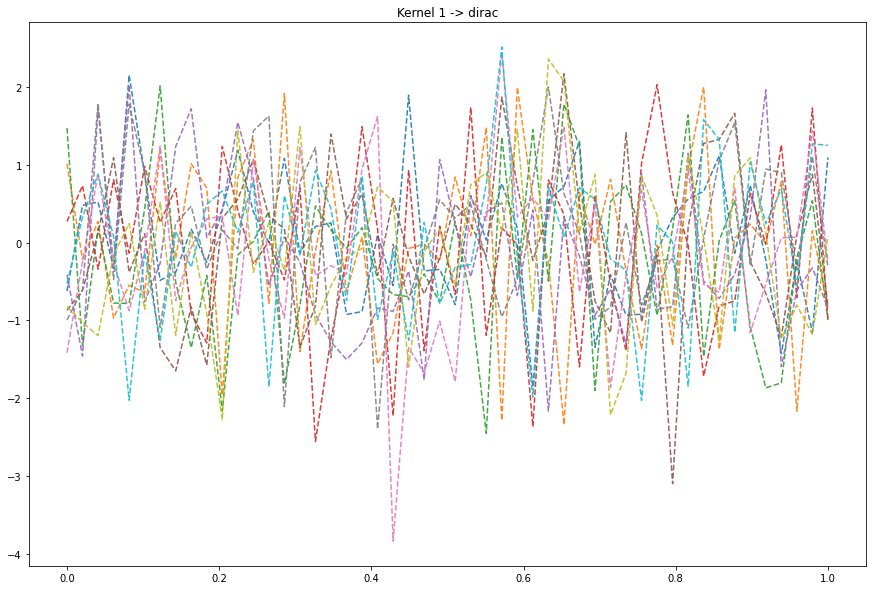

In [118]:
def kernel1(s, t):
    if s == t:
        return 1
    return 0

indices = np.linspace(0, 1, num = 50)
mu = np.zeros((indices.size))
k = np.zeros((indices.size, indices.size))
for i, xi in enumerate(indices):
    for j, xj in enumerate(indices):
        k[i, j] = kernel1(xi, xj)
for _ in range(10):
    plt.plot(indices, gp_sample(mu, k), '--', alpha=0.9)
plt.title('Kernel 1 -> dirac')

Text(0.5, 1.0, 'Kernel 2, w=1000, a=0.5')

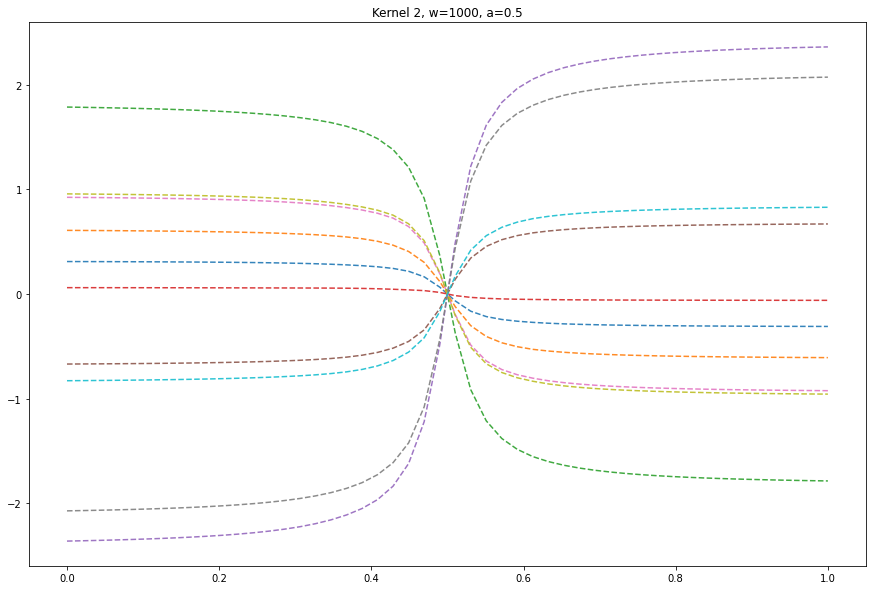

In [142]:
def kernel2(s, t, w=1000, a=0.5):
    return np.arcsin((w*(s - a)*(t - a))/(np.sqrt((w*(s-a)*(s-a) + 1)*(w*(t-a)*(t-a) + 1))))

indices = np.linspace(0, 1, num = 50)
mu = np.zeros((indices.size))
k = np.zeros((indices.size, indices.size))
for i, xi in enumerate(indices):
    for j, xj in enumerate(indices):
        k[i, j] = kernel2(xi, xj)
for _ in range(10):
    plt.plot(indices, gp_sample(mu, k), '--', alpha=0.9)    
plt.title(f'Kernel 2, w={1000}, a={0.5}')

Text(0.5, 1.0, 'Kernel 2, w=2, a=0')

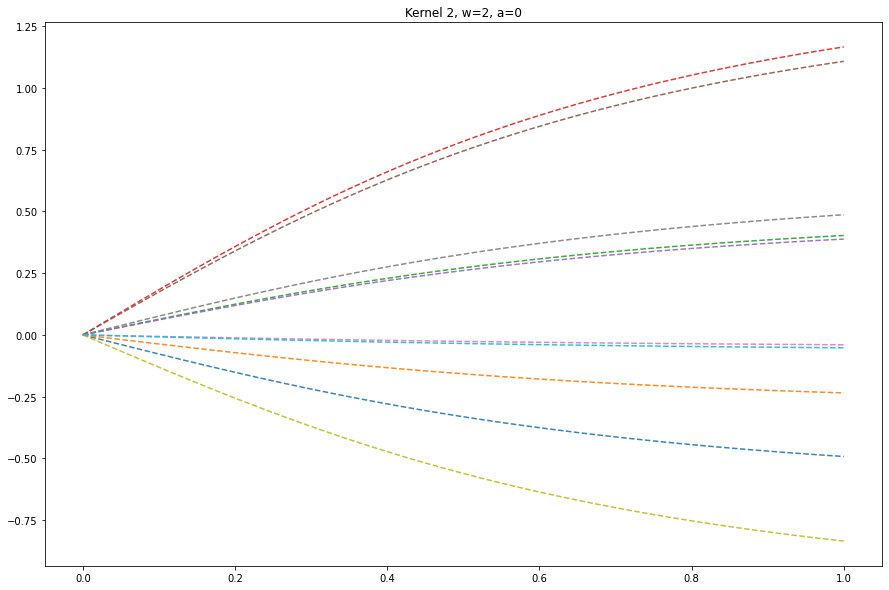

In [148]:
indices = np.linspace(0, 1, num = 50)
mu = np.zeros((indices.size))
k = np.zeros((indices.size, indices.size))
for i, xi in enumerate(indices):
    for j, xj in enumerate(indices):
        k[i, j] = kernel2(xi, xj, 2, 0)
for _ in range(10):
    plt.plot(indices, gp_sample(mu, k), '--', alpha=0.9)    
plt.title('Kernel 2, w=2, a=0')

Text(0.5, 1.0, 'Kernel 3, a=-1')

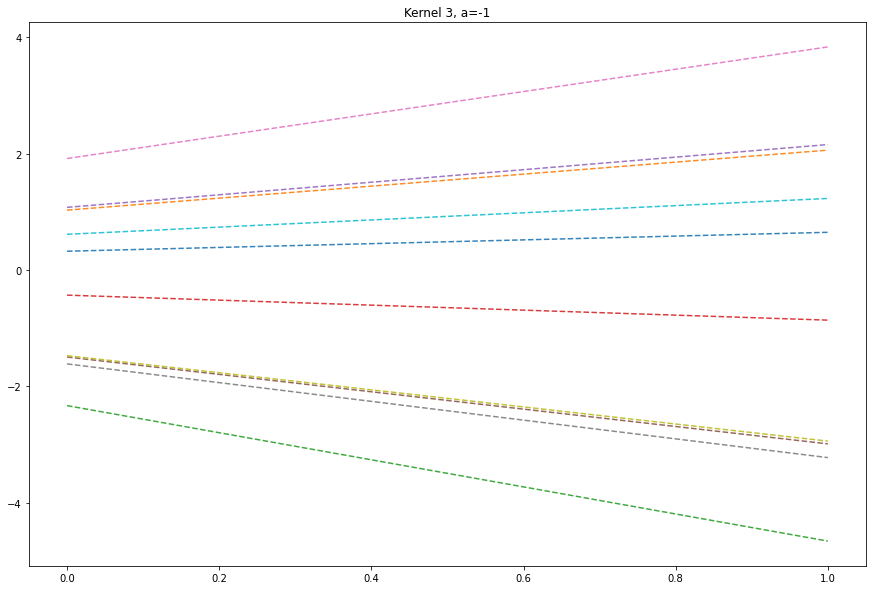

In [144]:
def kernel3(s, t, a=-1):
    return (s - a)*(t - a)

indices = np.linspace(0, 1, num = 50)
mu = np.zeros((indices.size))
k = np.zeros((indices.size, indices.size))
for i, xi in enumerate(indices):
    for j, xj in enumerate(indices):
        k[i, j] = kernel3(xi, xj)
for _ in range(10):
    plt.plot(indices, gp_sample(mu, k), '--', alpha=0.9)    
plt.title('Kernel 3, a=-1')

Text(0.5, 1.0, 'Kernel 3, a=0.5')

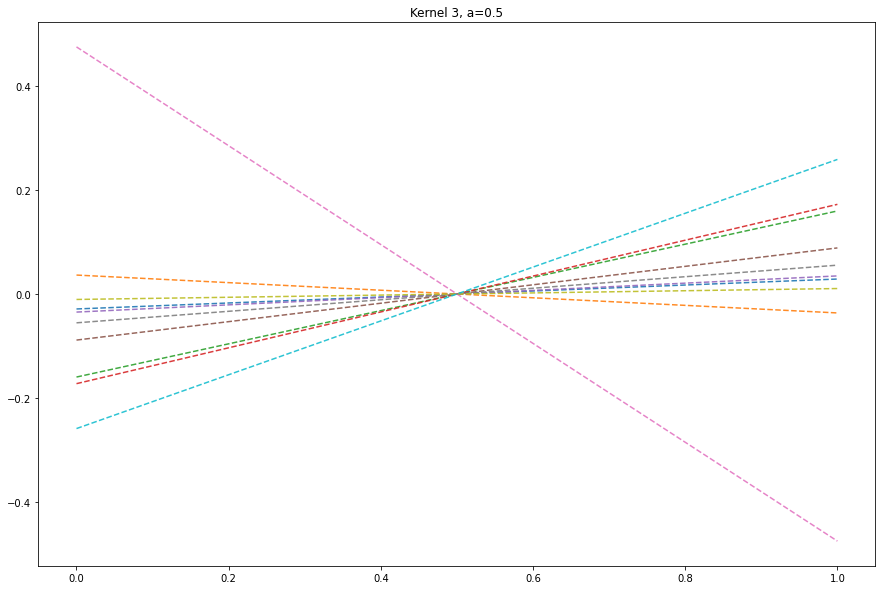

In [145]:
indices = np.linspace(0, 1, num = 50)
mu = np.zeros((indices.size))
k = np.zeros((indices.size, indices.size))
for i, xi in enumerate(indices):
    for j, xj in enumerate(indices):
        k[i, j] = kernel3(xi, xj, 0.5)
for _ in range(10):
    plt.plot(indices, gp_sample(mu, k), '--', alpha=0.9)    
plt.title('Kernel 3, a=0.5')

## Poisson Process

### Generate Poisson Process

Generate a poisson process with 100 samples. You should draw two plots:
1. The location of the events on the time axis.
2. The graph of the total number of events cumulatively (horizontal axis is again time.)

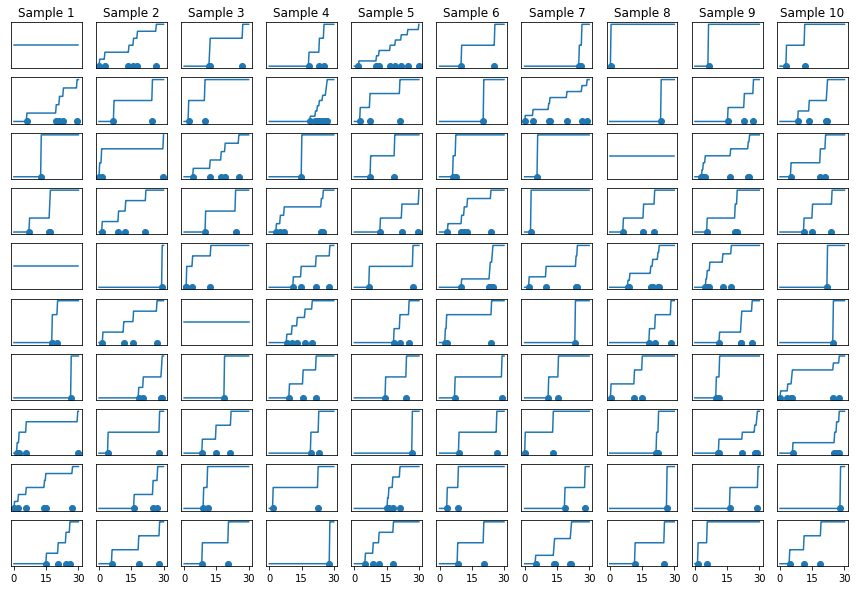

In [164]:
from scipy.stats import expon

def find_number(arr, t):
    if len(arr) == 0:
        return 0
    for i, v in enumerate(arr):
        if v >= t:
            return i
    return len(arr)

def poisson_sample(t, lambdaa = 0.1): # returns one poisson sample (N, arr_times)
    rv = expon(scale = 1/lambdaa)
    s = 0
    ret = []
    while True:
        temp = rv.rvs(size = 1)[0]
        if s + temp > t:
            return len(ret), ret
        s += temp
        ret.append(s)
    

𝜆 = 0.1    #Don't change its value.
for i in range(1, 101):
    plt.subplot(10, 10, i)
    if i <= 10:
        plt.title(f'Sample {i}')
    n, arr = poisson_sample(30)
    plt.scatter(arr, [0 for _  in range(len(arr))])
    if i >= 91:
        plt.xticks([0, 15, 30])
    else:
        plt.xticks([])
    plt.yticks([])
    plt.plot(np.linspace(0, 30, num=100), [find_number(arr, i) for i in np.linspace(0, 30, num=100)])
    
    

### Expectation of number of samples

1. Generate a poission process consisting of 10000 samples.
2. Sample 1000 random intervals (1000 start points and 1000 end points)
3. Compute number of points in each interval
3. Draw the graph of number of samples w.r.t. interval length
4. Conclude the relationship between expectation of number of samples and interval length.

In [172]:
samples = [None] * 10_000
for i in range(10_000):
    samples[i] = poisson_sample(100)[1]

    
times = []
nums = []

for i in range(1000):
    s, t = np.random.uniform(0, 100), np.random.uniform(0, 100)
    s, t = min(s, t), max(s, t)
    
    num = 0
    for arr in samples:
        num += find_number(arr, t) - find_number(arr, s)
    num /= len(samples)
    
    times.append(t - s)
    nums.append(num)

nums = np.array(nums)[np.argsort(times)]
times = np.array(times)[np.argsort(times)]

Text(0.5, 1.0, 'Number of events vs length of time intervals')

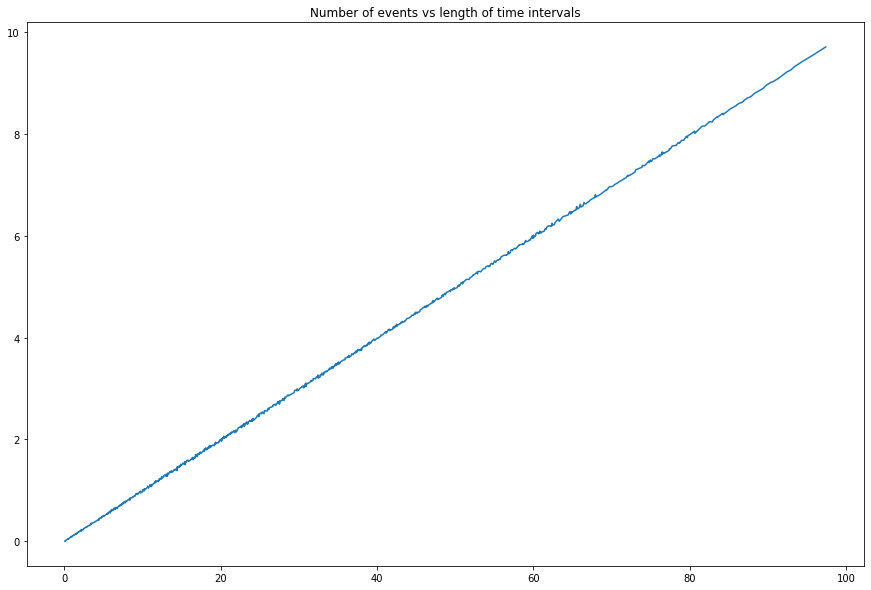

In [179]:
plt.plot(times, nums)
plt.title('Number of events vs length of time intervals')

Relation of time and number of events is linear.

### Estimate the pdf
In this section, we want to estimate $\lambda$.
1. Generate a poission process consisting of 10000 samples.
2. For each consecutive interval of length 100 compute the number of samples
3. Estimate the PDF
4. Compute the real PDF (possion distribution)
5. Compare estimated and real distributions in a single graph

### MLE of $\lambda$ in poisson distribution

The maximum likelihood estimator for $\lambda$ in poisson distribution is given by:
$$
\hat{\lambda} = \frac{1}{n}\sum_iX_i
$$

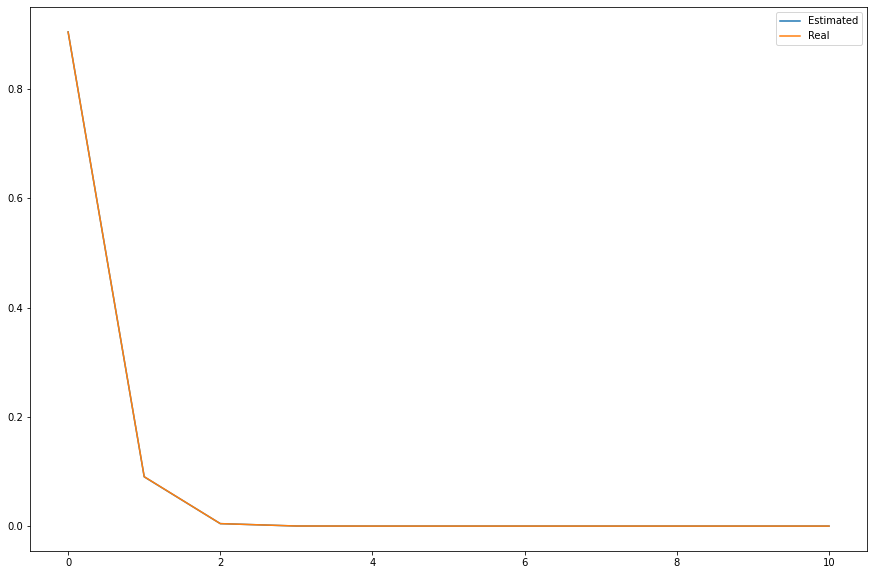

In [184]:
from scipy.stats import poisson

samples = [None] * 10_000
numbers = [0] * 10_000

for i in range(10_000):
    numbers[i], samples[i] = poisson_sample(100)

    
lambdaa_hat = np.array(numbers).mean() /100
rv_estimate = poisson(lambdaa_hat)
rv = poisson(𝜆)

plt.plot(np.linspace(0, 10, num=11), [rv_estimate.pmf(i) for i in np.linspace(0, 10, num=11)])
plt.plot(np.linspace(0, 10, num=11), [rv.pmf(i) for i in np.linspace(0, 10, num=11)])
plt.legend(['Estimated', 'Real'])


Two plots are right on top of each other. With 10000 samples MLE was able to correctly estimate $\lambda$ parameter.

## Hawkes Process
Besides Gaussian and Poisson, there are many other point processes. In this section, we want to get familiar with another point process named the **Hawkes Process**. <br>
So far, we have learned about the processes in which there is assumption of independence. However, there are other processes in which each event that occurs stochastically at a time $t_i$ adds more intensity to the process and increases the probability of subsequent events. Such processes are called **self-exciting processes**. <br>

Hawkes Process is a self-exciting process. The (univariate) Hawkes process is defined as below:
$$\lambda^*(t) = \mu + \sum_{t_i < t} \varphi(t - t_i)$$

As you can see, it depends linearly on the effects of events that have occurred before time $t$.
Namely, this dependence is through a triggering kernel function $φ(.)$ which is
a function of the delay $t−t_i$ between the current time and the timestamp of the previous event.This function is usually a monotonically decreasing function.<br><br>
The most commonly used kernel function is exponential decay:
$$\varphi(x) = \alpha \beta \exp (-\beta x)$$

In this section, you should
1. Generate a Hawkes Process which its kernel function is exponential decay consisting of 200 samples. [set α=0.1 , β=0.2 , 𝜇=0.1]
2. Try to change values of these 3 variables and find out how they affect the process. (Please write the impact of each.)
3. What kind of real-world processes do you think the Hawkes Process can simulate?

**Note:** In a single figure, plot time of events' occurrences and conditional intensity function ($\lambda^*(t)$)<br>
**Note:** To check the effect of each variable, draw some plots in a separate figures where only that variable has changed. (Your final answer should include three figures.) 

First we need to solve the following problem. Suppose that at $t=t_n$ an event has occured. What is the distribution of the time difference between this event and the next event.

Define $X$ to be the time interval starting from event $n$ ( $n \in \{0, 1, \dots\}$ ) at time $t_n$. If we can find $F_x$ then we can easily sample from the said distribution.

$$
\mathbb{P}[X <= t] = \mathbb{P}[Y > 0] \quad,\quad Y \sim \text{Pois}(\int_{t_n}^t\lambda^*(x)\,dx)
$$
$$
= 1 - \mathbb{P}[Y = 0] = 1 - e^{-\lambda(t)}
$$

Now we have to find $\lambda(t)$:

$$
\lambda(t) = \int_{t_n}^t\lambda^*(x)\,dx = \int_{t_n}^t \mu + \sum_{i = 1}^n\alpha\beta e^{-\beta(x - t_i)}\,dx
$$
$$
= \mu(t - t_n) + \sum_{i = 1}^n\alpha\beta\int_{t_n}^te^{-\beta(x - t_i)}\,dx
$$
$$
= \mu(t - t_n) + \sum_{i = 1}^n-\alpha(e^{-\beta(t - t_i)}-e^{-\beta(t_n - t_i)})
$$
$$
= \mu(t - t_n) + \alpha(e^{-\beta t_n} - e^{-\beta t})(\sum_{i = 1}^ne^{\beta t_i})
$$

Note that for the first event, the followind CDF is the same as $\text{exp}(\mu)$.

Now we can start sampling from the CDF.

In [215]:
def binary_search(f, val, start = 0, end = 10000):
    l = start
    p = end
    while True:
        if abs(l - p) <= 1e-6:
            return (l + p) / 2
        m = (l + p) / 2
        if f(m) >= val:
            p = m
        else:
            l = m
            
def sample_from_cdf(cdf, start, end):
    p = np.random.random()
    return binary_search(cdf, p, start, end)

In [327]:
def func(t, h, a, b, m):
    s = 0
    for i in h:
        s += np.exp(b*i)
    if len(h) != 0:
        s *= a*(np.exp(-b*h[-1]) - np.exp(-b*t))
    if len(h) != 0:
        s += m*(t - h[-1])
    else:
        s += m*t
    return 1-np.exp(-s)

def func2(t, h, a, b, m):
    if len(h) == 0:
        return m
    if t < h[0]:
        return m
    
    idx = len(h) - 1
    while idx >= 0:
        if h[idx] <= t:
            s = m
            for i in range(idx + 1):
                s += phi_ker(t - h[i], a, b)
            return s
        idx -= 1

def phi_ker(x, a, b):
    return a*b*np.exp(-b*x)
    

def hawkes_sample(alpha=0.1, beta=0.2, mu=0.1):
    max_time = 100
    history = []
    last = 0
    while True:
        cdf = lambda t: func(t=t, h=history, a=alpha, b=beta, m=mu)
        temp = sample_from_cdf(cdf, 0 if len(history) == 0 else history[-1], 10000)
        if temp >= max_time:
            return history
        last = temp
        history.append(last)

def hawkes_sample_def(alpha=0.1, beta=0.2, mu=0.1): # return hawkes sample plus lambda star
    max_time = 100
    history = []
    last = 0
    
    while True:
        cdf = lambda t: func(t=t, h=history, a=alpha, b=beta, m=mu)
        temp = sample_from_cdf(cdf, 0 if len(history) == 0 else history[-1], 10000)
        if temp >= max_time:
            break
        last = temp
        history.append(last)
    
    return history, lambda t:func2(t, history, alpha, beta, mu)
        

Text(0.5, 1.0, '$\\lambda^*$ with alpha = 0.1, beta=0.2, mu=0.1')

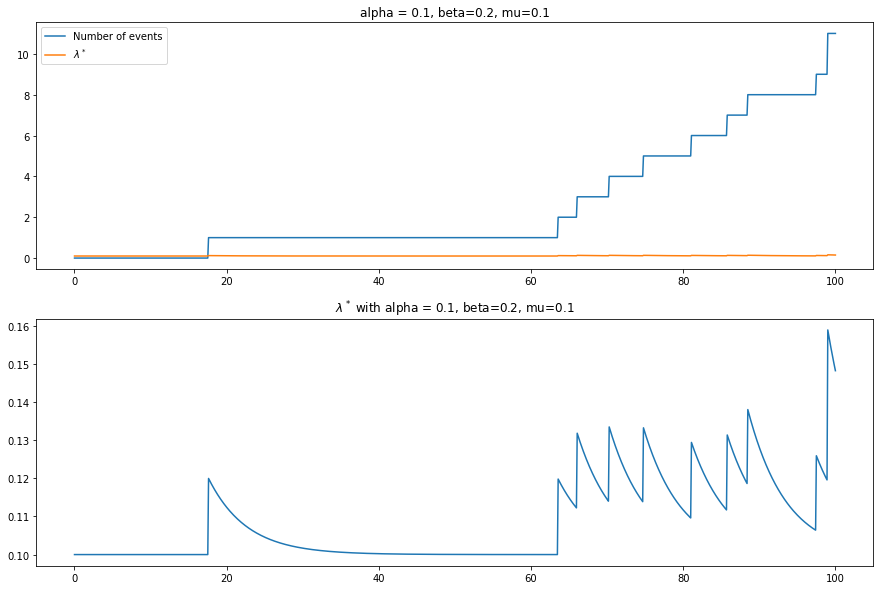

In [349]:
arr, f = hawkes_sample_def(alpha=0.1, beta=0.2, mu=0.1)
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, 100, num=1000), [find_number(arr, i) for i in np.linspace(0, 100, num=1000)])
plt.plot(np.linspace(0, 100, num=1000), [f(i) for i in np.linspace(0, 100, num=1000)])
plt.title('alpha = 0.1, beta=0.2, mu=0.1')
plt.legend(['Number of events', '$\lambda^*$'])

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, 100, num=1000), [f(i) for i in np.linspace(0, 100, num=1000)])
plt.title('$\lambda^*$ with alpha = 0.1, beta=0.2, mu=0.1')

Now we can generate 200 samples. (5 samples in each graph)

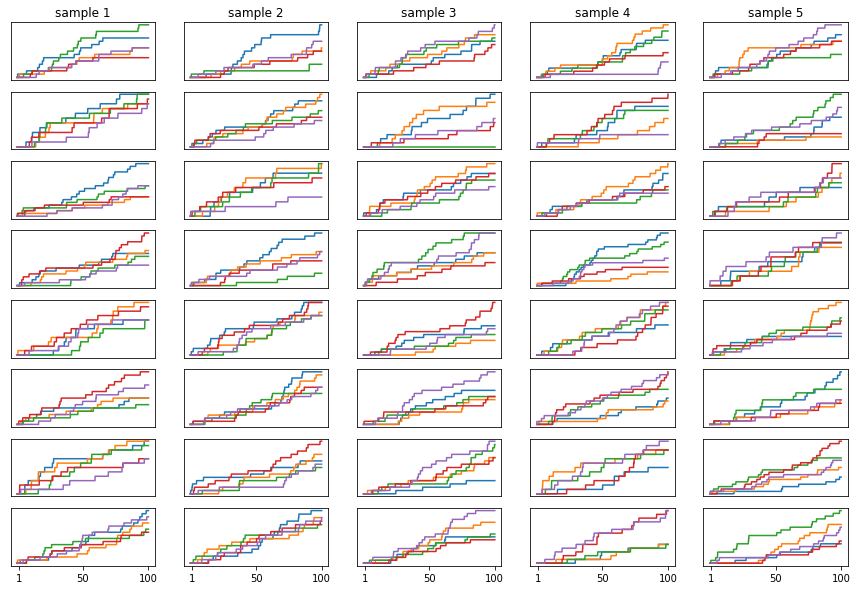

In [352]:
for i in range(1, 41):
    plt.subplot(8, 5, i)
    for _ in range(5):
        arr = hawkes_sample()
        plt.plot(np.linspace(0, 100, num=1000), [find_number(arr, i) for i in np.linspace(0, 100, num=1000)])
    if i <= 5:
        plt.title(f'sample {i}')
    plt.xticks([])
    if i >= 36:
        plt.xticks([1, 50, 100])
    plt.yticks([])

Now we can check the effect of each parameter.
### Change in $\beta$ :

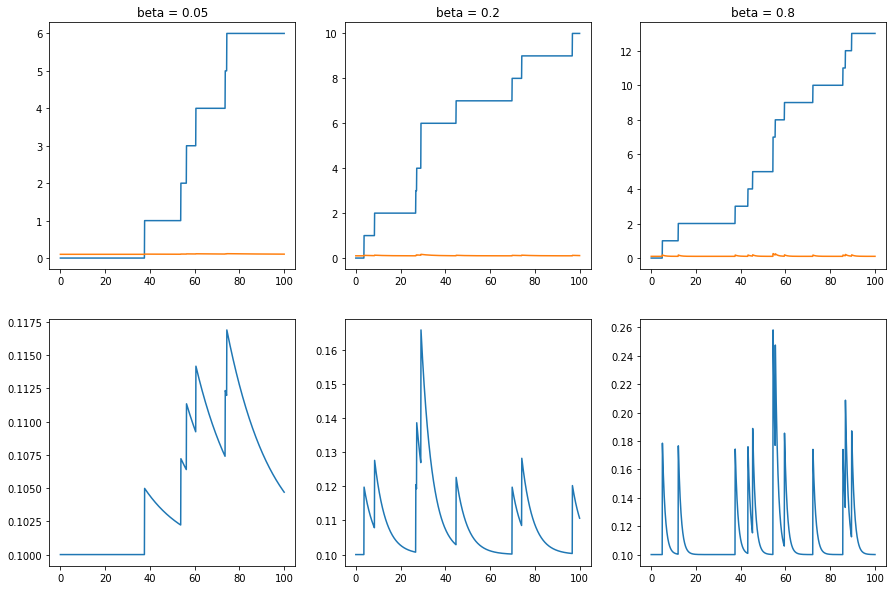

In [354]:
betas = [0.05, 0.2, 0.8]

for i in range(1, 4):
    plt.subplot(2, 3, i)
    arr, f = hawkes_sample_def(alpha=0.1, beta=betas[i - 1], mu=0.1)
    plt.plot(np.linspace(0, 100, num=1000), [find_number(arr, i) for i in np.linspace(0, 100, num=1000)])
    plt.plot(np.linspace(0, 100, num=1000), [f(i) for i in np.linspace(0, 100, num=1000)])
    plt.title(f'beta = {betas[i - 1]}')
    
    plt.subplot(2, 3, i + 3)
    plt.plot(np.linspace(0, 100, num=1000), [f(i) for i in np.linspace(0, 100, num=1000)])
    


$\beta$ controls the persistency of the effect. Meaning that how fast can we forget the history.

### Change in $\alpha$ :


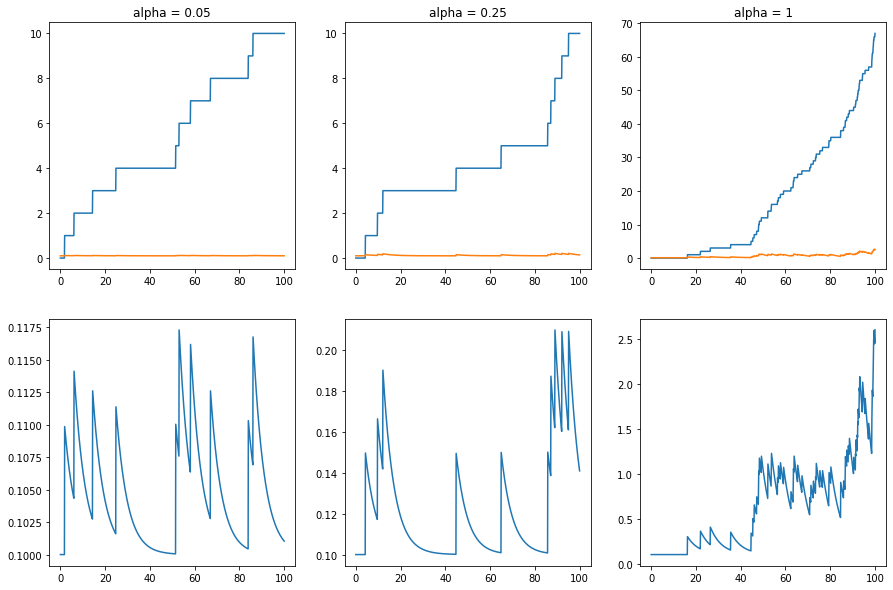

In [360]:
alphas = [0.05, 0.25, 1]

for i in range(1, 4):
    plt.subplot(2, 3, i)
    arr, f = hawkes_sample_def(alpha=alphas[i - 1], beta=0.2, mu=0.1)
    plt.plot(np.linspace(0, 100, num=1000), [find_number(arr, i) for i in np.linspace(0, 100, num=1000)])
    plt.plot(np.linspace(0, 100, num=1000), [f(i) for i in np.linspace(0, 100, num=1000)])
    plt.title(f'alpha = {alphas[i - 1]}')
    
    plt.subplot(2, 3, i + 3)
    plt.plot(np.linspace(0, 100, num=1000), [f(i) for i in np.linspace(0, 100, num=1000)])

$\alpha$ shows the amount of effect of the history. for example for $\alpha = 0$, the history has no effect on the trend. The higher $\alpha$ goes, effect of past events on future events is increased.

### Change in $\mu$ :


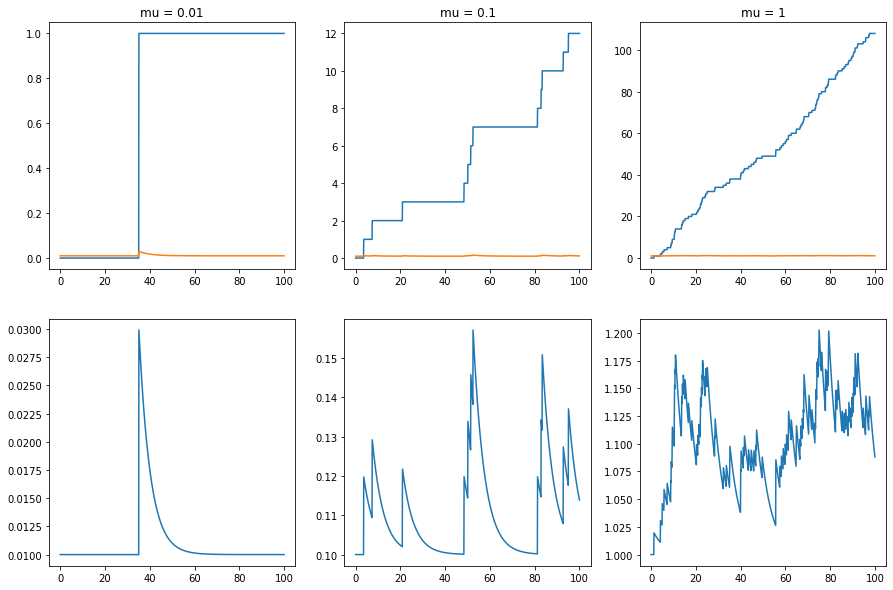

In [362]:
mus = [0.01, 0.1, 1]

for i in range(1, 4):
    plt.subplot(2, 3, i)
    arr, f = hawkes_sample_def(alpha=0.1, beta=0.2, mu=mus[i - 1])
    plt.plot(np.linspace(0, 100, num=1000), [find_number(arr, i) for i in np.linspace(0, 100, num=1000)])
    plt.plot(np.linspace(0, 100, num=1000), [f(i) for i in np.linspace(0, 100, num=1000)])
    plt.title(f'mu = {mus[i - 1]}')
    
    plt.subplot(2, 3, i + 3)
    plt.plot(np.linspace(0, 100, num=1000), [f(i) for i in np.linspace(0, 100, num=1000)])

First of all $\mu$ determines the first event. For higher $\mu$'s the first event happens a lot faster.

Second $\mu$ marks the baseline of the $\lambda^*$ function.

Increasing $\mu$ means that more events happend which have effect on the future events. It's also clear to see that for $\mu=0$ no events will happen.

### What phenomenons can we model with hawkes process

There are many applications to the hawkes process. A good example could be social media events. Because they are mostly self-exciting.

Suppose that each event is a user tweeting about some news. Then the rate of tweets for an specific amount of time increases and decreases as time goes by. Until another user tweets about the same news.